Code used to take GPX from RAAM website into useable data format for rest race analysis

In [1]:
#import libraries
import gpxpy
import gpxpy.gpx
import csv
import pandas as pd
import requests
import math
import uuid
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd

# define file locations to import and export
gpx_file_path = '/Users/nickstatz/Desktop/RAAM/RawDownloads/RAAM2024 GPS Exchange (final).gpx'
df_GPS_track_path = '/Users/nickstatz/Desktop/RAAM/df_GPS_track.csv'
segment_df_csv_path = '/Users/nickstatz/Desktop/RAAM/segments.csv'

In [2]:
# gpx to df 

# GPX file from RAAM GPS page https://40bdd70f-2135-4870-ab11-131a8a088964.filesusr.com/ugd/49fb96_2d5bd542879d4c809203ae55bd76e50f.gpx?dn=RAAM2024%20GPS%20Exchange%20(final).gpx
#gpx_file_path = '/Users/nickstatz/Desktop/RAAM/RawDownloads/RAAM2024 GPS Exchange (final).gpx'

# Open and parse the GPX file
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
    
#create empty list
points = []

# parse gpx file
for segment in gpx.tracks[0].segments:
    for p in segment.points:
        points.append((p.latitude,p.longitude,p.elevation,))

#write to df and csv
df = pd.DataFrame.from_records(points)
df_v2 = df.drop_duplicates()
dropped_dups = abs(len(df_v2)-len(df))
print("df1: ",len(df)," df_v2: ", len(df_v2)," Dropped rows: ",dropped_dups)

#df_GPS_track_path = '/Users/nickstatz/Desktop/RAAM/df_GPS_track.csv'
df_v2.to_csv(df_GPS_track_path)
points_v2 = list(df_v2.itertuples(index=False, name=None))
print("v1: ", len(points), " v2: ",len(points_v2))

df1:  47742  df_v2:  47705  Dropped rows:  37
v1:  47742  v2:  47705


In [ ]:
# create segments - from Steve W.
segments = []

# first segment
segment={}
segment['start'] = {}
segment['start']['latitude'] = points_v2[0][0]
segment['start']['longitude'] = points_v2[0][1]
segment['start']['elev']=points_v2[0][2]
segment['start']['id'] = uuid.uuid4()
segment['end'] = {}
segment['end']['latitude'] = points_v2[1][0]
segment['end']['longitude'] = points_v2[1][1]
segment['end']['elev']=points_v2[1][2]
segment['end']['id'] = uuid.uuid4()
segments.append(segment)

# remaining segments
for i in range(1, len(points_v2)-1):
    segment={}
    segment['start'] = {}
    segment['start']['latitude'] = points_v2[i][0]
    segment['start']['longitude'] = points_v2[i][1]
    segment['start']['elev']=points_v2[i][2]
    segment['start']['id'] = segments[i-1]['end']['id']
    segment['end'] = {}
    segment['end']['latitude'] = points_v2[i+1][0]
    segment['end']['longitude'] = points_v2[i+1][1]
    segment['end']['elev']=points_v2[i+1][2]
    segment['end']['id'] = uuid.uuid4()
    segments.append(segment)
    
segments

In [ ]:
# get distance of each seg - originally tried using OSRM open API but error in total distance was significant

def distance_in_m(lat1,lon1,lat2,lon2):
    # haversine function coords must be in radians
    lat_1 = math.radians(lat1)
    lat_2 = math.radians(lat2)
    lon_1 = math.radians(lon1)
    lon_2 = math.radians(lon2)
    change_lat = lat_2-lat_1
    change_lon = lon_2-lon_1
    a=math.sqrt((math.sin(change_lat/2))**2+math.cos(lat_1)*math.cos(lat_2)*(math.sin(change_lon/2))**2)
    d=2*6371000*math.asin(a)
    return d

for seg in segments:
    seg['dist_m'] = distance_in_m(seg['start']['latitude'],seg['start']['longitude'],seg['end']['latitude'],seg['end']['longitude'])
segments

#determine heading for each segment - from Steve W.
def calculate_heading(segment):
    lat_a = segment['start']['latitude']
    lon_a = segment['start']['longitude']
    lat_b = segment['end']['latitude']
    lon_b = segment['end']['longitude']
    x = math.cos(lat_b) * math.sin(lon_a - lon_b)
    y = math.cos(lat_a) * math.sin(lat_b) - math.sin(lat_a) * math.cos(lat_b) * math.cos(lon_a - lon_b)
    bearing = math.atan2(x,y)
    return bearing

for seg in segments:
    seg['bearing'] = calculate_heading(seg)


In [6]:
#Updated bearing calculation - was getting results inconsistent with expected
def calculate_bearing(segment):
    """
    Calculate the bearing between two points. From https://www.igismap.com/formula-to-find-bearing-or-heading-angle-between-two-points-latitude-longitude/
    
    Parameters:
    segment from track to calculate bearing of
    
    Returns:
    Bearing in degrees from the 'from' point to the 'end' point
    
    All the angles are measured w.r.t North Direction
    Angles measured clockwise are +ve and anti-clockwise are -ve
    """
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(segment['start']['latitude'])
    lon1 = math.radians(segment['start']['longitude'])
    lat2 = math.radians(segment['end']['latitude'])
    lon2 = math.radians(segment['end']['longitude'])

    # Calculate the differences
    delta_lon = lon2 - lon1
    
    # Calculate the components of the bearing
    y = (math.cos(lat1) * math.sin(lat2)) - (math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon))
    x = math.cos(lat2) * math.sin(delta_lon)
    
    # Calculate the bearing
    beta = math.atan2(x,y)
    
    # Convert the bearing from radians to degrees
    degrees = math.degrees(beta)

    return degrees

for seg in segments:
    seg['bearing'] = calculate_bearing(seg)

In [ ]:
# determine slope of each segment
for seg in segments:
    if seg['dist_m'] != 0:
        seg['slope'] = (seg['end']['elev']-seg['start']['elev'])/seg['dist_m']
segments[:5]

In [ ]:
# calculate cumulative distance to beginning of segment
total_dist = 0
for seg in segments:
    seg['cumulative_distance_to_segment'] = total_dist
    total_dist += seg['dist_m']
segments

In [9]:
# assign unique id to each segment
for segment in segments:
    segment['seg_id'] = str(uuid.uuid4())

In [10]:
def create_segment_df(segments):

    rows = []

    for seg in segments:
        rows.append({
                        'from_lat': seg['start']['latitude'], 
                        'from_lon': seg['start']['longitude'], 
                        'from_elevation': seg['start']['elev'] if 'elev' in segment['start'].keys() else "",
                        'to_lat': seg['end']['latitude'], 
                        'to_lon': seg['end']['longitude'], 
                        'to_elevation': seg['end']['elev'] if 'elev' in segment['end'].keys() else "",
                        'length_m': seg['dist_m'], 
                        'bearing': seg['bearing'], 
                        'slope': seg['slope'] if 'slope' in segment.keys() else None,
                        'segment_id': seg['seg_id'],
                        'cumulative_distance_to_segment': seg['cumulative_distance_to_segment']
                    }) 

        df = pd.DataFrame(rows)

    return df

In [13]:
segment_df = create_segment_df(segments)

In [14]:
segment_df_csv_path = '/Users/nickstatz/Desktop/RAAM/segments.csv'
segment_df.to_csv(segment_df_csv_path,index = False)

In [ ]:
# export segments as pickle
import pickle

# df to pkl
segment_df.to_pickle('segment_df.pkl')


# list of dicts to pkl
f = open('segments_original.pkl', "wb")
pickle.dump(segments, f)
f.close()

trythis = pickle.load( open( 'segments_original.pkl', 'rb' ) )
trythis_df = pickle.load( open( 'segment_df.pkl', 'rb' ) )

trythis_df

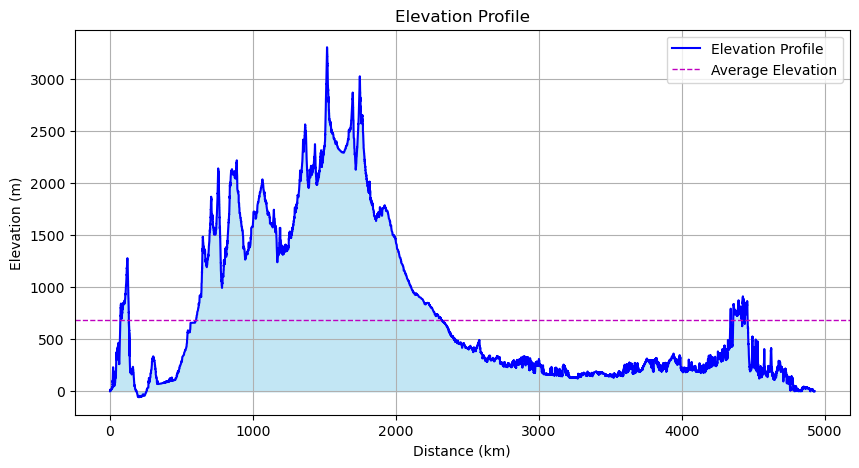

In [16]:
#Create Elevation Plot

distances = segment_df['cumulative_distance_to_segment'].to_list()
elevations = segment_df['to_elevation'].to_list()
distances_km = [d / 1000 for d in distances]
average_elevation = sum(elevations) / len(elevations)

#PLOT ELEVATION PROFILE
# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(distances_km, elevations, linestyle='-', color='b', linewidth=1.5, label='Elevation Profile')

# Plot the average elevation line
plt.axhline(y=average_elevation, color='m', linestyle='--', linewidth=1, label='Average Elevation')

# Customize the plot
plt.title('Elevation Profile')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.grid(True)
plt.legend()  # Add a legend to differentiate the lines
plt.fill_between(distances_km, elevations, color='skyblue', alpha=0.5)

# Display the plot
plt.savefig('elevation_profile_map.png', dpi=300)
plt.show()

/var/folders/rd/q0cb2t154gl8yv342sm8kzsh0000gn/T/ipykernel_66372/1127698150.py:16: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


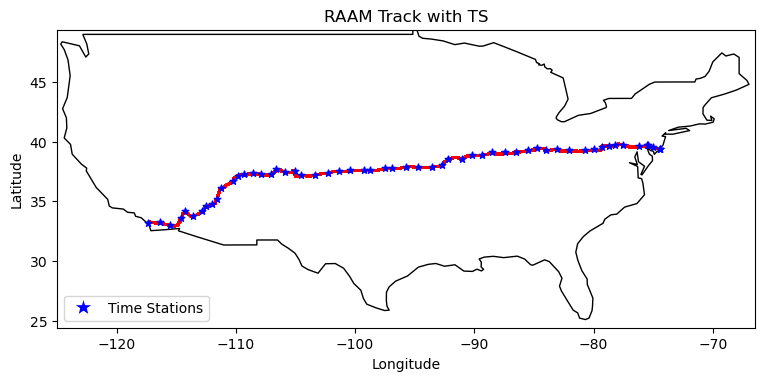

In [17]:
import geopandas as gpd


# downloadable from RAAM GPS Info page: https://www.raamrace.org/_files/ugd/49fb96_42d3e9a89c2841d9b955857c94f9bc33.csv?dn=RAAM2024%20Time%20Stations%20(final).csv
timeStationPath = '/Users/nickstatz/Desktop/RAAM/RawDownloads/RAAM2024 Time Stations (final).csv'
ts_coords = pd.read_csv(timeStationPath)

# Create a GeoDataFrame
try:
    gdf = gpd.GeoDataFrame(
        segment_df, geometry=gpd.points_from_xy(segment_df.from_lon, segment_df.from_lat))
except Exception as e:
    print(f"Error creating GeoDataFrame: {e}")

# Load a map of the United States
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us = world[(world.name == "United States of America")]

# Plot the US map
ax = us.plot(figsize=(9, 6), color='white', edgecolor='black')

# Plot the points on the map
gdf.plot(ax=ax, color='red', markersize=1)

# Set x and y limits to focus on the US
ax.set_xlim([-125, -66.5])  # Longitude range
ax.set_ylim([24.396308, 49.384358])  # Latitude range

# Add title and labels
ax.set_title('RAAM Track with TS')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

for idx, row in ts_coords.iterrows():
    ax.scatter(row['Longitude'], row['Latitude-N'], marker = '*',label = row['Name'], color='blue', s=25)
    
# Create a custom legend
custom_markers = [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', markersize=15, label='Time Stations')
]

# Add the custom legend
ax.legend(handles=custom_markers, loc='lower left')

# Save the plot to a file
plt.savefig('RAAM_Track.png', dpi=300)

# Display the plot
plt.show()


In [28]:
south = segment_df[segment_df["bearing"]==180]
south
# all of these are headed straigh south, most are short enough could remove?

,from_lat,from_lon,from_elevation,to_lat,to_lon,to_elevation,length_m,bearing,slope,segment_id,cumulative_distance_to_segment
9059,37.262381,-109.305926,1358.6,37.262339,-109.305926,1358.3,4.678766,180.0,-0.064119,d1bd1f85-f333-4cc7-b4d2-ca24455cfbeb,1.234361e+06
13889,37.447796,-105.036474,2307.4,37.447543,-105.036474,2308.6,28.137838,180.0,0.042647,4c6a18b7-f74f-4c89-a3b4-b025a36499d5,1.727489e+06
13902,37.441549,-105.036028,2326.4,37.441297,-105.036028,2328.2,28.016675,180.0,0.064247,a4300f5b-b963-4aaf-ad53-aafb6a61f1f4,1.728186e+06
14189,37.361471,-105.105979,2651.2,37.360888,-105.105979,2651.6,64.822346,180.0,0.006171,b77f454e-abfe-4225-be73-1ac4510f099a,1.740015e+06
24371,38.889582,-89.413460,179.1,38.888665,-89.413460,177.3,101.972867,180.0,-0.017652,df202aca-44ba-440f-a492-6435188403b1,3.340838e+06
25467,39.113082,-87.494252,157.1,39.112843,-87.494252,157.1,26.581356,180.0,0.000000,8ca779d0-9de4-4ac1-9caa-4ca43ee95911,3.534019e+06
30078,39.372695,-84.173247,230.8,39.372576,-84.173247,230.4,13.225436,180.0,-0.030245,e4e7e14f-dc28-4ed8-b6f1-9969856366cf,3.888967e+06
33081,39.259948,-81.484634,215.4,39.259415,-81.484634,217.5,59.267477,180.0,0.035433,2afbe684-fe31-4eb1-9ed7-b21e63308f17,4.167125e+06
33709,39.286501,-80.733384,255.0,39.286500,-80.733384,255.0,0.111843,180.0,0.000000,67d3a989-9b65-497a-a920-307911b1aa57,4.239149e+06
37240,39.407069,-79.407299,733.6,39.407068,-79.407299,733.6,0.111843,180.0,0.000000,2ea412e5-4ef8-423e-ae8b-c439fd622e28,4.387793e+06


# Old----------------------------------------------------------------------------

In [5]:
#create list from df of coordinate points to be used
    #lat_lon_list = df[['latitude','longitude']].values.tolist()
lat_lon_list_v2 = df_v2[['latitude','longitude']].values.tolist()

#list to tuple - apparently tuples are faster to work with
    #lat_lon_tuples = [tuple(sublist) for sublist in lat_lon_list]
lat_lon_tuples_v2 = [tuple(sublist) for sublist in lat_lon_list_v2]

#check
    #print("list length: ",len(lat_lon_list))
print("v2 list length: ",len(lat_lon_list_v2))

#check
    #print("tuple length: ",len(lat_lon_tuples))
print("v2 tuple length: ",len(lat_lon_tuples_v2))

v2 list length:  47705
v2 tuple length:  47705


#### Get distance between points

In [20]:
#incorporated
def degrees_to_radians(pair):
    lat, lon = pair
    return (math.radians(lat), math.radians(lon))
#lat_lon_rad_tup = [degrees_to_radians(coord) for coord in lat_lon_tuples]
lat_lon_rad_tup_v2 = [degrees_to_radians(coord) for coord in lat_lon_tuples_v2]

def distance_in_m(coord1, coord2):
    # haversine function coords must be in radians
    lat1,lon1 = coord1
    lat2,lon2 = coord2
    delta_lat = lat2-lat1
    delta_lon = lon2-lon1
    a=math.sqrt((math.sin(delta_lat/2))**2+math.cos(lat1)*math.cos(lat2)*(math.sin(delta_lon/2))**2)
    d=2*6371000*math.asin(a)
    return d

i = 0
dist_m = []
while i < len(lat_lon_rad_tup_v2)-1:
    c1 = lat_lon_rad_tup_v2[i]
    c2 = lat_lon_rad_tup_v2[i+1]
    dist = distance_in_m(c1,c2)
    dist_m.append(dist)
    i += 1
dist_m_df_v2 = pd.DataFrame(dist_m,columns = ['dist_m'])
dist_m_df_v2.to_csv('/Users/nickstatz/Desktop/RAAM/haversine_distance_meters_v2.csv',index = False)

#### Get Bearings

In [8]:
# look further into coord to radian and radian to bearing conversion - do we want angle from b to a 
    # or need to convert to a to b
def road_direction(coord1, coord2):
    lat_a, lon_a = coord1
    lat_b, lon_b = coord2
    x = math.cos(lat_b) * math.sin(lon_a - lon_b)
    y = math.cos(lat_a) * math.sin(lat_b) - math.sin(lat_a) * math.cos(lat_b) * math.cos(lon_a - lon_b)
    bearing = math.atan2(x,y)
    return bearing

i = 0
bearings = []
while i < len(lat_lon_rad_tup_v2)-1:
    c1 = lat_lon_rad_tup_v2[i]
    c2 = lat_lon_rad_tup_v2[i+1]
    direction = road_direction(c1,c2)
    bearings.append(direction)
    i += 1
bearing_df = pd.DataFrame(bearings,columns = ['bearing_rad'])
bearing_df.to_csv('/Users/nickstatz/Desktop/RAAM/bearings_rad.csv',index = False)

In [25]:
overall = road_direction(lat_lon_tuples_v2[0],lat_lon_tuples_v2[47704])
overall

-2.7265606457059497